# COMP1801 - Machine Learning Coursework Solution

Let’s start by importing the essential Python libraries for data analysis and machine learning.

In [111]:
# Import libraries
try:
    # Importing general libraries
    import os
    import glob
    import pandas as pd
    import joblib

    # Importing libraries for data visualization
    import matplotlib.pyplot as plt
    import numpy as np

    # Importing libraries for model building
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

    # Importing libraries for data preprocessing
    from scipy.stats import randint

except Exception as e:
    print(f"Error : {e}")

In [112]:
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

for file in file_list:
    print(f"Found file: {file}")

# Ensure there is exactly one file
if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

Found file: ../Datasets/Dataset.csv
Loaded dataset: ../Datasets/Dataset.csv


In [113]:
# File path to save the trained model
destination = '../Models/'
os.makedirs(destination, exist_ok=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lifespan        1000 non-null   float64
 1   partType        1000 non-null   object 
 2   microstructure  1000 non-null   object 
 3   coolingRate     1000 non-null   int64  
 4   quenchTime      1000 non-null   float64
 5   forgeTime       1000 non-null   float64
 6   HeatTreatTime   1000 non-null   float64
 7   Nickel%         1000 non-null   float64
 8   Iron%           1000 non-null   float64
 9   Cobalt%         1000 non-null   float64
 10  Chromium%       1000 non-null   float64
 11  smallDefects    1000 non-null   int64  
 12  largeDefects    1000 non-null   int64  
 13  sliverDefects   1000 non-null   int64  
 14  seedLocation    1000 non-null   object 
 15  castType        1000 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 125.1+ KB


In [115]:
# Check for missing values
df.isnull().sum()

Lifespan          0
partType          0
microstructure    0
coolingRate       0
quenchTime        0
forgeTime         0
HeatTreatTime     0
Nickel%           0
Iron%             0
Cobalt%           0
Chromium%         0
smallDefects      0
largeDefects      0
sliverDefects     0
seedLocation      0
castType          0
dtype: int64

In [116]:
df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die


In [117]:
df.describe()

,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1298.556320,17.639000,2.764230,5.464600,30.194510,60.243080,24.553580,12.434690,2.768650,17.311000,0.550000,0.292000
std,340.071434,7.491783,1.316979,2.604513,16.889415,5.790475,7.371737,4.333197,1.326496,12.268365,1.163982,1.199239
min,417.990000,5.000000,0.500000,1.030000,1.030000,50.020000,6.660000,5.020000,0.510000,0.000000,0.000000,0.000000
25%,1047.257500,11.000000,1.640000,3.170000,16.185000,55.287500,19.387500,8.597500,1.590000,7.000000,0.000000,0.000000
50%,1266.040000,18.000000,2.755000,5.475000,29.365000,60.615000,24.690000,12.585000,2.865000,18.000000,0.000000,0.000000
75%,1563.050000,24.000000,3.970000,7.740000,44.955000,65.220000,29.882500,16.080000,3.922500,26.000000,0.000000,0.000000
max,2134.530000,30.000000,4.990000,10.000000,59.910000,69.950000,43.650000,19.990000,4.990000,61.000000,4.000000,8.000000


In [118]:
# Using nunique()
num_parts = df['partType'].nunique()
print(f"Number of unique parts types: {num_parts}")

# Or using value_counts() to see the distribution
parts_distribution = df['partType'].value_counts()
print("\nDistribution of parts types:")
print(parts_distribution)

Number of unique parts types: 4

Distribution of parts types:
partType
Valve     265
Block     253
Nozzle    245
Blade     237
Name: count, dtype: int64


In [119]:
categorical_cols_unfied = ['partType', 'microstructure', 'seedLocation', 'castType']

# Create a DataFrame to display unique values and their counts
unique_values_df = pd.DataFrame({
    'Column': categorical_cols_unfied,
    'Unique Values': [df[col].unique().tolist() for col in categorical_cols_unfied],
    'Count of Unique Values': [df[col].nunique() for col in categorical_cols_unfied]
})

print(unique_values_df)

           Column                       Unique Values  Count of Unique Values
0        partType       [Nozzle, Block, Blade, Valve]                       4
1  microstructure  [equiGrain, singleGrain, colGrain]                       3
2    seedLocation                       [Bottom, Top]                       2
3        castType       [Die, Investment, Continuous]                       3


In [120]:
# Creating a copy of the dataframe to ensure we maintain the original intact
df_label_encoded = df.copy()
encoder = "Label Encoding"

# Apply Label Encoding to each categorical column
label_encoders = {}
for col in categorical_cols_unfied:
    le = LabelEncoder()
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])
    label_encoders[col] = le  # Store the encoder for inverse transformation if needed later

# Display the first few rows to verify
display(df_label_encoded.head())

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1469.17,2,1,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,0,1
1,1793.64,1,2,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,0,2
2,700.60,0,1,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,0,2
3,1082.10,2,0,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,1,0
4,1838.83,0,0,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,1,1


In [121]:
df_label_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lifespan        1000 non-null   float64
 1   partType        1000 non-null   int64  
 2   microstructure  1000 non-null   int64  
 3   coolingRate     1000 non-null   int64  
 4   quenchTime      1000 non-null   float64
 5   forgeTime       1000 non-null   float64
 6   HeatTreatTime   1000 non-null   float64
 7   Nickel%         1000 non-null   float64
 8   Iron%           1000 non-null   float64
 9   Cobalt%         1000 non-null   float64
 10  Chromium%       1000 non-null   float64
 11  smallDefects    1000 non-null   int64  
 12  largeDefects    1000 non-null   int64  
 13  sliverDefects   1000 non-null   int64  
 14  seedLocation    1000 non-null   int64  
 15  castType        1000 non-null   int64  
dtypes: float64(8), int64(8)
memory usage: 125.1 KB


In [122]:
# Define the target variable and feature set
X = df_label_encoded.drop(columns=['Lifespan'])  # Features
y = df_label_encoded['Lifespan']  # Target

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets to verify
print(f'--- {encoder} Shape ---\n')
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

--- Label Encoding Shape ---

X_train shape: (800, 15)
X_test shape: (200, 15)
y_train shape: (800,)
y_test shape: (200,)


In [ ]:
# Initialize the Random Forest Regressor with default parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using RMSE, R² Score, and MAE
rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
msle = mean_squared_log_error(y_test, y_pred)  # Mean Squared Log Error

print(f'--- {encoder} Performance ---\n')
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R\u00b2 Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Log Error (MSLE): {msle:.2f}")

--- Label Encoding Performance ---

Root Mean Squared Error (RMSE): 90.95
R² Score: 0.92
Mean Absolute Error (MAE): 72.50
Mean Squared Log Error (MSLE): 0.01


In [ ]:
print(f"\nFeatures saved with {encoder}\n")
for col in X.columns:
    print(f"- {col}")

In [124]:
# Features to drop based on low importance for Label Encoding
low_importance_features = ['seedLocation', 'microstructure', 'castType', 'smallDefects', 'sliverDefects']

In [125]:
print(f"--- {encoder} Shape Reduction ---")

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets to verify
print("\nOriginal Shapes")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Features to drop based on low importance
low_importance_features = ['seedLocation', 'microstructure', 'castType', 'smallDefects', 'sliverDefects']

# Create a new DataFrame excluding these features
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

# Display the shapes of the training and testing sets to verify
print("\nUpdated Shapes")
print("X_train_reduced shape:", X_train_reduced.shape)
print("X_test_reduced shape:", X_test_reduced.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

--- Label Encoding Shape Reduction ---

Original Shapes
X_train shape: (800, 15)
X_test shape: (200, 15)
y_train shape: (800,)
y_test shape: (200,)

Updated Shapes
X_train_reduced shape: (800, 10)
X_test_reduced shape: (200, 10)
y_train shape: (800,)
y_test shape: (200,)


In [ ]:
# Initialize the Random Forest Regressor with best parameters
rf_model = RandomForestRegressor(
    max_depth=15,
    n_estimators=387,
    random_state=42
)

# Fit the model to the training data
rf_model.fit(X_train_reduced, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_reduced)

# Evaluate the model using RMSE, R² Score, and MAE
rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
msle = mean_squared_log_error(y_test, y_pred)  # Mean Squared Log Error

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R\u00b2 Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Log Error (MSLE): {msle:.2f}")

Root Mean Squared Error (RMSE): 88.10
R² Score: 0.93
Mean Absolute Error (MAE): 70.68
Mean Squared Log Error (MSLE): 0.01


In [127]:
# Creating a copy of the dataframe to ensure we maintain the original intact
df_onehot_encoded = df.copy()
encoder = "One-Hot Encoding"

# Apply one-hot encoding to the categorical columns
df_onehot_encoded = pd.get_dummies(df_onehot_encoded, columns=categorical_cols_unfied, drop_first=False)

# Display the first few rows to verify
display(df_onehot_encoded.head())

,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,...,partType_Nozzle,partType_Valve,microstructure_colGrain,microstructure_equiGrain,microstructure_singleGrain,seedLocation_Bottom,seedLocation_Top,castType_Continuous,castType_Die,castType_Investment
0,1469.17,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,...,True,False,False,True,False,True,False,False,True,False
1,1793.64,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,...,False,False,False,False,True,True,False,False,False,True
2,700.60,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,...,False,False,False,True,False,True,False,False,False,True
3,1082.10,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,...,True,False,True,False,False,False,True,True,False,False
4,1838.83,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,...,False,False,True,False,False,False,True,False,True,False


In [128]:
df_onehot_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Lifespan                    1000 non-null   float64
 1   coolingRate                 1000 non-null   int64  
 2   quenchTime                  1000 non-null   float64
 3   forgeTime                   1000 non-null   float64
 4   HeatTreatTime               1000 non-null   float64
 5   Nickel%                     1000 non-null   float64
 6   Iron%                       1000 non-null   float64
 7   Cobalt%                     1000 non-null   float64
 8   Chromium%                   1000 non-null   float64
 9   smallDefects                1000 non-null   int64  
 10  largeDefects                1000 non-null   int64  
 11  sliverDefects               1000 non-null   int64  
 12  partType_Blade              1000 non-null   bool   
 13  partType_Block              1000 n

In [129]:
# Define the target variable and feature set
X = df_onehot_encoded.drop(columns=['Lifespan'])  # Features
y = df_onehot_encoded['Lifespan']  # Target

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets to verify
print(f'--- {encoder} Shape ---\n')
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

--- One-Hot Encoding Shape ---

X_train shape: (800, 23)
X_test shape: (200, 23)
y_train shape: (800,)
y_test shape: (200,)


In [ ]:
# Initialize the Random Forest Regressor with default parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using RMSE, R² Score, and MAE
rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
msle = mean_squared_log_error(y_test, y_pred)  # Mean Squared Log Error

print(f'--- {encoder} Performance ---\n')
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R\u00b2 Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Log Error (MSLE): {msle:.2f}")

--- One-Hot Encoding Performance ---

Root Mean Squared Error (RMSE): 85.15
R² Score: 0.93
Mean Absolute Error (MAE): 67.46
Mean Squared Log Error (MSLE): 0.01


In [131]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Corrected values for max_features
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_rf_model = grid_search.best_estimator_
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_e

In [132]:
# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 500),  # Randomly sample number of trees between 100 and 500
    'max_depth': [None] + list(range(10, 50, 5)),  # None or range from 10 to 50, step 5
    'min_samples_split': randint(2, 20),  # Random split values between 2 and 20
    'min_samples_leaf': randint(1, 10),  # Random leaf values between 1 and 10
    'max_features': ['sqrt', 'log2', None]  # Use predefined feature subsets
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1,
                                   scoring='neg_mean_squared_error')

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Get the best estimator and parameters
best_rf_model = random_search.best_estimator_
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=35, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.2s
[CV] END max_depth=35, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.2s
[CV] END max_depth=35, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=158; total time=   0.1s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=413; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=413; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=158; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimator

In [ ]:
# Train the final model with the best parameters with the best parameters
final_rf_model = RandomForestRegressor(
    max_depth=15,
    n_estimators=387,
    random_state=42
)

print(f'--- Generating model with {encoder} ---')

# Fit the model to the training data
final_rf_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(final_rf_model, f'{destination}Final-RFModel.pkl')

--- Generating model with One-Hot Encoding ---


['../Models/Final-RFModel.pkl']

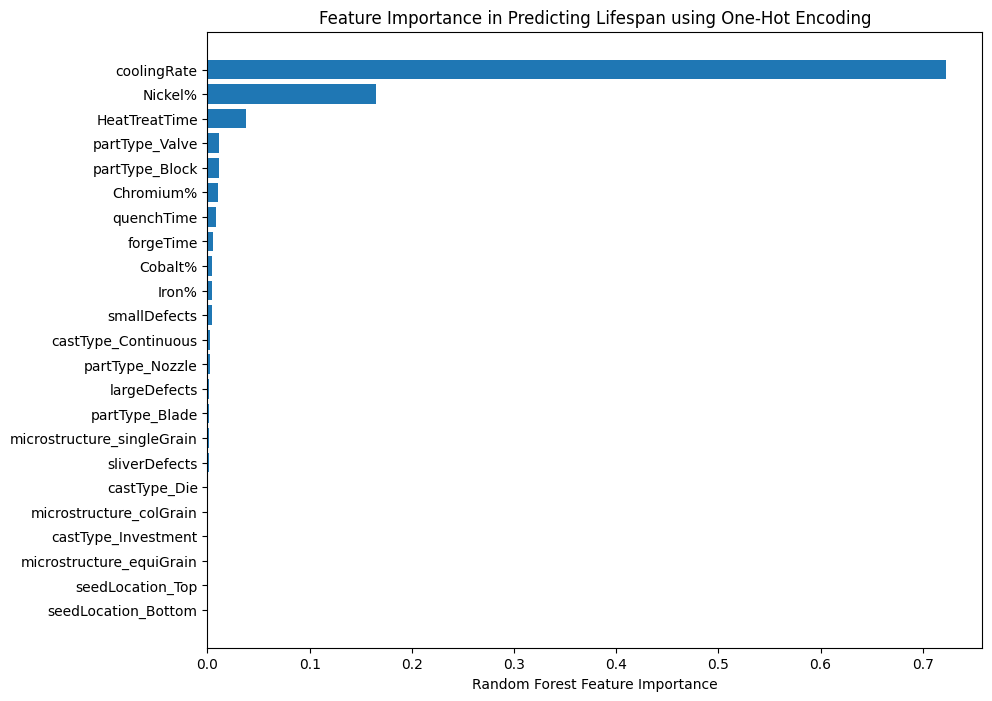

In [134]:
# Feature importance analysis
feature_importances = final_rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title(f"Feature Importance in Predicting Lifespan using {encoder}")
plt.show()

In [135]:
print(f"\nFeatures saved with {encoder}\n")
for col in X.columns:
    print(f"- {col}")


Features saved with One-Hot Encoding

- coolingRate
- quenchTime
- forgeTime
- HeatTreatTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- smallDefects
- largeDefects
- sliverDefects
- partType_Blade
- partType_Block
- partType_Nozzle
- partType_Valve
- microstructure_colGrain
- microstructure_equiGrain
- microstructure_singleGrain
- seedLocation_Bottom
- seedLocation_Top
- castType_Continuous
- castType_Die
- castType_Investment


In [136]:
# Selecting only the most important features (those with non-zero or significant importance)
important_features = ['partType_Blade', 'partType_Block', 'partType_Nozzle', 'partType_Valve', 'coolingRate', 'Nickel%', 'HeatTreatTime', 'Chromium%' , 'quenchTime']
X_important = df_onehot_encoded[important_features]

print(f'--- {encoder} Updated Performance ---\n')

# Split the dataset and retrain the model
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor with reduced features with the best parameters
rf_model_imp = RandomForestRegressor(
    max_depth=15,
    n_estimators=387,
    random_state=42
)
rf_model_imp.fit(X_train_imp, y_train_imp)

# Evaluate the model
y_pred_imp = rf_model_imp.predict(X_test_imp)
rmse_imp = root_mean_squared_error(y_test_imp, y_pred_imp)
r2_imp = r2_score(y_test_imp, y_pred_imp)
mae_imp = mean_absolute_error(y_test_imp, y_pred_imp)
msle_imp = mean_squared_log_error(y_test_imp, y_pred_imp)

print(f"Reduced Features RMSE: {rmse_imp:.2f}")
print(f"Reduced Features R² Score: {r2_imp:.2f}")
print(f"Reduced Features MAE: {mae_imp:.2f}")
print(f"Reduced Features MSLE: {msle_imp:.2f}")

--- One-Hot Encoding Updated Performance ---

Reduced Features RMSE: 78.70
Reduced Features R² Score: 0.94
Reduced Features MAE: 61.14
Reduced Features MSLE: 0.01


In [137]:
import sklearn
print(sklearn.__version__)

1.5.2


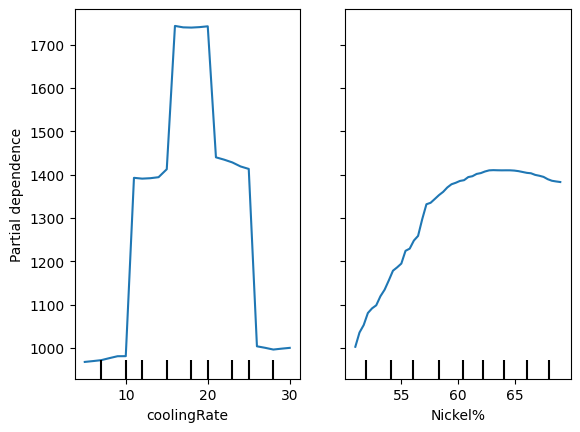

In [138]:
from sklearn.inspection import PartialDependenceDisplay

# Plot partial dependence for important features using the new API
features_to_plot = ['coolingRate', 'Nickel%']
PartialDependenceDisplay.from_estimator(rf_model_imp, X_train_imp, features_to_plot, grid_resolution=50)
plt.show()

In [139]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error

# Define the model with best-found hyperparameters
rf_model_cv = RandomForestRegressor(
    max_depth=15,
    n_estimators=387,
    min_samples_leaf=2,
    min_samples_split=3,
    random_state=42
)

# Define the scoring metric: RMSE
scorer = make_scorer(root_mean_squared_error)

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(rf_model_cv, X_important, y, cv=5, scoring=scorer)

# Print results
print("Cross-Validation RMSE scores for each fold: ", cv_scores)
print(f"Mean CV RMSE: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV RMSE: {cv_scores.std():.2f}")

Cross-Validation RMSE scores for each fold:  [77.55548306 74.97658535 77.56023918 82.12528196 81.38495862]
Mean CV RMSE: 78.72
Standard Deviation of CV RMSE: 2.66


In [140]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Separate features for encoding
onehot_features = ['microstructure', 'seedLocation', 'castType']
label_features = ['partType']

# Custom transformers
label_encoder = LabelEncoder()
df['partType'] = label_encoder.fit_transform(df['partType'])  # Apply label encoding directly

# Create a ColumnTransformer for One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_features)
    ],
    remainder='passthrough'  # Keeps all other features as they are
)

# Define pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        max_depth=15,
        n_estimators=387,
        min_samples_leaf=2,
        min_samples_split=3,
        random_state=42
    ))
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Lifespan']), df['Lifespan'], test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSLE: {msle:.2f}")

RMSE: 89.91
R² Score: 0.92
MAE: 71.64
MSLE: 0.01
